# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Import Resources

In [296]:
import json
import numpy as np
import seaborn as sns

import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.saving import register_keras_serializable


print("TensorFlow version:", tf.__version__)
print("TensorFlow Hub version:", hub.__version__)

TensorFlow version: 2.19.0
TensorFlow Hub version: 0.16.1


In [297]:
def plot_images_with_numeric_labels(dataset_split, n=1, max_per_row=10):
    """
    Plots n images from the dataset split using their numeric label as title.

    Args:
        dataset_split (tf.data.Dataset): e.g. dataset['train']
        n (int): Number of images to plot
        max_per_row (int): Max number of images per row
    """
    cols = min(n, max_per_row)
    rows = (n + cols - 1) // cols

    plt.figure(figsize=(cols * 2.5, rows * 2.5))

    for i, example in enumerate(dataset_split.take(n)):
        image = example['image']
        label = example['label'].numpy()

        plt.subplot(rows, cols, i + 1)
        plt.imshow(image)
        plt.title(f"Label: {label}", fontsize=9)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def plot_flowers_with_class_names(dataset_split, n=1, label_map_path='label_map.json', max_per_row=10):
    """
    Plots n images from a dataset split with class names as titles.

    Args:
        dataset_split (tf.data.Dataset): The dataset split to sample from.
        n (int): Number of images to display.
        label_map_path (str): Path to the JSON label map file.
        max_per_row (int): Maximum number of images per row.
    """
    # Load label map
    with open(label_map_path, 'r') as f:
        class_names = json.load(f)

    # Grid layout
    cols = min(n, max_per_row)
    rows = (n + cols - 1) // cols

    plt.figure(figsize=(cols * 2.5, rows * 2.5))

    for i, example in enumerate(dataset_split.take(n)):
        image = example['image']
        label = example['label'].numpy()
        label_name = class_names[str(label)]

        plt.subplot(rows, cols, i + 1)
        plt.imshow(image)
        plt.title(label_name, fontsize=9)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def preprocess(example, IMG_SIZE):
    image = tf.image.resize(example['image'], (IMG_SIZE, IMG_SIZE))  # Resize to 224x224
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to [0, 1]
    label = example['label']  # Keep label as is
    return image, label

## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [298]:
dataset_name= 'oxford_flowers102'
dataset, dataset_info = tfds.load(dataset_name, as_supervised=False, with_info=True)

In [299]:
dataset_info.description

'The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly\noccurring in the United Kingdom. Each class consists of between 40 and 258\nimages. The images have large scale, pose and light variations. In addition,\nthere are categories that have large variations within the category and several\nvery similar categories.\n\nThe dataset is divided into a training set, a validation set and a test set. The\ntraining set and validation set each consist of 10 images per class (totalling\n1020 images each). The test set consists of the remaining 6149 images (minimum\n20 per class).\n\nNote: The dataset by default comes with a test size larger than the train size.\nFor more info see this\n[issue](https://github.com/tensorflow/datasets/issues/3022).'

In [300]:
# Extract splits
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']


as_supervised=True loads the data as (image, label) pairs.
The oxford_flowers102 dataset already includes:'train', 'validation', 'test'
with_info=True returns metadata about the dataset (e.g., number of classes, size, etc.).

## Explore the Dataset

In [301]:
num_classes = dataset_info.features['label'].num_classes
print("Train samples:", dataset_info.splits['train'].num_examples)
print("Validation samples:", dataset_info.splits['validation'].num_examples)
print("Test samples:", dataset_info.splits['test'].num_examples)
print("Number of Classes is: ", num_classes)

Train samples: 1020
Validation samples: 1020
Test samples: 6149
Number of Classes is:  102


Example 1
Label index: 72
Label name : water lily
Image shape: (500, 667, 3)



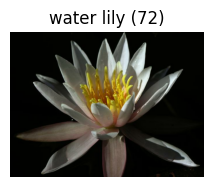

Example 2
Label index: 84
Label name : desert-rose
Image shape: (500, 666, 3)



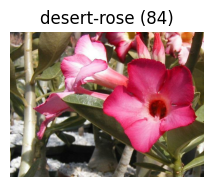

Example 3
Label index: 70
Label name : gazania
Image shape: (670, 500, 3)



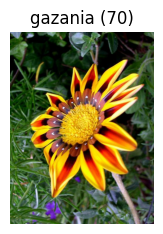

In [302]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
for i, example in enumerate(dataset['train'].take(3)):
    image = example['image']
    label = example['label'].numpy()
    label_name = label_names[label]

    print(f"Example {i+1}")
    print(f"Label index: {label}")
    print(f"Label name : {label_name}")
    print(f"Image shape: {image.shape}")
    print("")

    plt.figure(figsize=(2.5, 2.5))
    plt.imshow(image)
    plt.title(f"{label_name} ({label})")
    plt.axis('off')
    plt.show()

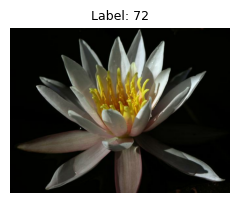

In [303]:
# TODO: Plot 1 image from the training set. Set the title # of the plot to the corresponding image label.   
plot_images_with_numeric_labels(dataset['train'], n=1)


### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [304]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)


In [305]:
class_names

{'0': 'pink primrose',
 '1': 'hard-leaved pocket orchid',
 '2': 'canterbury bells',
 '3': 'sweet pea',
 '4': 'english marigold',
 '5': 'tiger lily',
 '6': 'moon orchid',
 '7': 'bird of paradise',
 '8': 'monkshood',
 '9': 'globe thistle',
 '10': 'snapdragon',
 '11': "colt's foot",
 '12': 'king protea',
 '13': 'spear thistle',
 '14': 'yellow iris',
 '15': 'globe-flower',
 '16': 'purple coneflower',
 '17': 'peruvian lily',
 '18': 'balloon flower',
 '19': 'giant white arum lily',
 '20': 'fire lily',
 '21': 'pincushion flower',
 '22': 'fritillary',
 '23': 'red ginger',
 '24': 'grape hyacinth',
 '25': 'corn poppy',
 '26': 'prince of wales feathers',
 '27': 'stemless gentian',
 '28': 'artichoke',
 '29': 'sweet william',
 '30': 'carnation',
 '31': 'garden phlox',
 '32': 'love in the mist',
 '33': 'mexican aster',
 '34': 'alpine sea holly',
 '35': 'ruby-lipped cattleya',
 '36': 'cape flower',
 '37': 'great masterwort',
 '38': 'siam tulip',
 '39': 'lenten rose',
 '40': 'barbeton daisy',
 '41': '

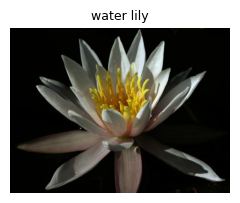

In [306]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 

plot_flowers_with_class_names(dataset['train'],n=1)


## Create Pipeline

This is one of the most important parts of preparing data for a deep learning model in TensorFlow. We’re preparing image data to be fed into a neural network, with steps like: Resizing,Normalizing,Shuffling,Batching.

As we have seen, Images in the dataset have different sizes → we need consistent size for batching and model input.
Pixel values are from 0 to 255 → we scale them to [0, 1] so the model trains more efficiently.

This pipeline takes raw image data and converts it into efficient, structured, model-ready batches with parallel loading, shuffling, and real-time prefetching — enabling fast, scalable, and high-performance training.


In [307]:
IMG_SIZE = 224    
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Apply preprocessing + batching
train_ds = dataset['train'] \
    .map(lambda x: preprocess(x, IMG_SIZE), num_parallel_calls=AUTOTUNE) \
    .shuffle(1000) \
    .batch(BATCH_SIZE) \
    .prefetch(AUTOTUNE)

val_ds = dataset['validation'] \
    .map(lambda x: preprocess(x, IMG_SIZE), num_parallel_calls=AUTOTUNE) \
    .batch(BATCH_SIZE) \
    .prefetch(AUTOTUNE)

test_ds = dataset['test'] \
    .map(lambda x: preprocess(x, IMG_SIZE), num_parallel_calls=AUTOTUNE) \
    .batch(BATCH_SIZE) \
    .prefetch(AUTOTUNE)

In [308]:
train_ds 

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

This URL points to a pre-trained MobileNetV2 model hosted on TensorFlow Hub, specifically trained on the ImageNet dataset. MobileNetV2 is a lightweight and efficient convolutional neural network designed for fast performance with relatively low computational cost, making it ideal for transfer learning. 

The "100_224" part indicates that it's the full-sized model (100% width) and expects input images of size 224x224 pixels, which aligns perfectly with our image preprocessing pipeline. 

The "feature_vector" suffix means we're loading **only the convolutional base of the model, without its original classification layer**. Instead of outputting class predictions, it returns a dense feature vector that represents high-level visual features extracted from the input image — which we can then feed into our own custom classification layer tailored to our specific task, such as classifying 102 types of flowers.

In [322]:
# TODO: Build and train your network.
EPOCHS = 7
num_classes = 102

# Load the model as a callable function
feature_extractor = hub.load("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4")

# Wrap it with a Lambda so Keras ca handle it
@register_keras_serializable()
def extract_features(x):
    return feature_extractor(x)['default'] if isinstance(feature_extractor(x), dict) else feature_extractor(x)

# Model definition
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3)) # Input layer: expects 224x224 RGB images
x = layers.Lambda(extract_features)(inputs) # Pass input through MobileNet (frozen)
x = layers.Dense(256, activation='relu')(x) # My own Classifier (Dense hidden layer)
x = layers.Dropout(0.3)(x) # Dropout for regularization
outputs = layers.Dense(num_classes, activation='softmax')(x)  # Output layer for 102 classes

model = Model(inputs, outputs)

# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_8 (Lambda)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 102)                 │          26,214 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 354,150 (1.35 MB)

 Trainable params: 354,150 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

In [323]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/7
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 620ms/step - accuracy: 0.0456 - loss: 4.7048 - val_accuracy: 0.2637 - val_loss: 3.7510
Epoch 2/7
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 595ms/step - accuracy: 0.3316 - loss: 3.3415 - val_accuracy: 0.5039 - val_loss: 2.4507
Epoch 3/7
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 624ms/step - accuracy: 0.6057 - loss: 1.9374 - val_accuracy: 0.6578 - val_loss: 1.6857
Epoch 4/7
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 595ms/step - accuracy: 0.7619 - loss: 1.0904 - val_accuracy: 0.6971 - val_loss: 1.3562
Epoch 5/7
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 617ms/step - accuracy: 0.8616 - loss: 0.7579 - val_accuracy: 0.7422 - val_loss: 1.1271
Epoch 6/7
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 636ms/step - accuracy: 0.9183 - loss: 0.4435 - val_accuracy: 0.7618 - val_loss: 1.0146
Epoch 7/7
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 597ms/step - accuracy: 0.9184 - loss: 0.3841 - val_accuracy: 0.7539 - val_loss: 0.9918


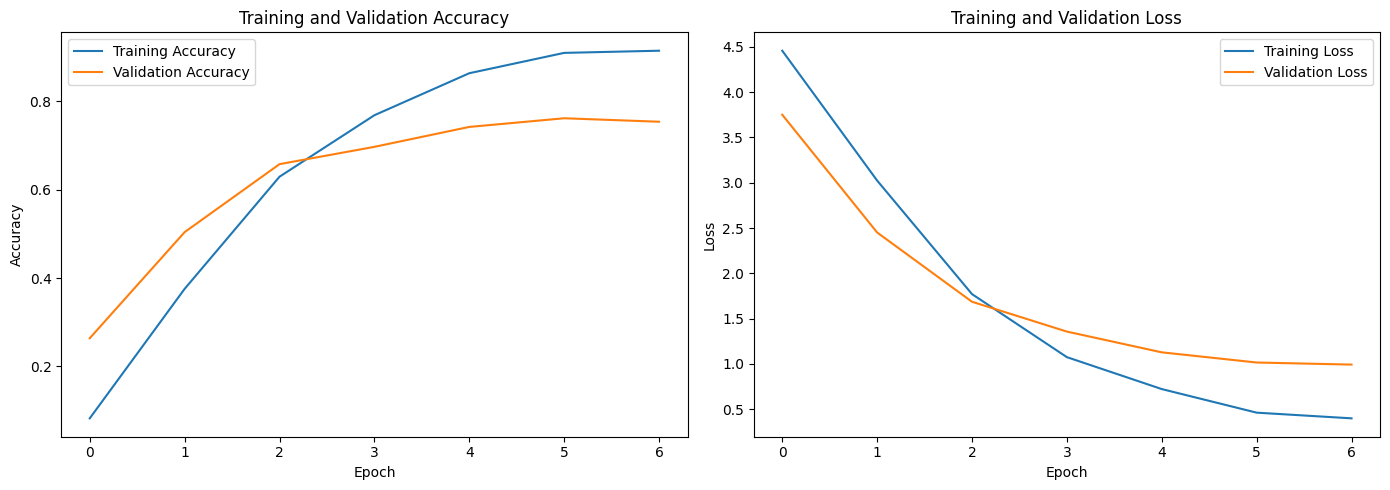

In [324]:
# Extract metrics from training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# Create plots
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

The model is learning well — both accuracies rise consistently.
The validation accuracy stabilizes after epoch 3–4, suggesting the model may be approaching its generalization limit (for this setup).

Training Loss: Drops quickly from ~4.4 to < 0.4 — a steep decline, showing the model fits the training data well.

Validation Loss: Decreases too, but flattens around epoch 4–5.

## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [325]:
# TODO: Print the loss and accuracy values achieved on the entire test set.

loss, accuracy = model.evaluate(test_ds)

print('\nLoss on the TEST Set: {:,.3f}'.format(loss))
print('Accuracy on the TEST Set: {:.3%}'.format(accuracy))

193/193 ━━━━━━━━━━━━━━━━━━━━ 57s 294ms/step - accuracy: 0.7345 - loss: 1.1222

Loss on the TEST Set: 1.114
Accuracy on the TEST Set: 73.166%


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [326]:
# TODO: Save your trained model as a Keras model.
model.save('flower_classifier_model_udacity_project.keras')
model.save('flower_classifier_model_udacity_project.h5')


## Load the Keras Model

Load the Keras model you saved above.

In [327]:
# TODO: Load the Keras model
# Rebuild the model structure
from tensorflow.keras.models import load_model

model = load_model(
    'flower_classifier_model_udacity_project.keras',
    custom_objects={'extract_features': extract_features}
)

model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_8 (Lambda)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 102)                 │          26,214 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,062,452 (4.05 MB)

 Trainable params: 354,150 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 708,302 (2.70 MB)

# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [328]:
# TODO: Create the process_image function


def process_image(image):
    """Preprocesses a NumPy image array for MobileNet input."""
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.image.resize(image, (224, 224))
    image /= 255.0  # Normalize to [0, 1]
    return image.numpy()

To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

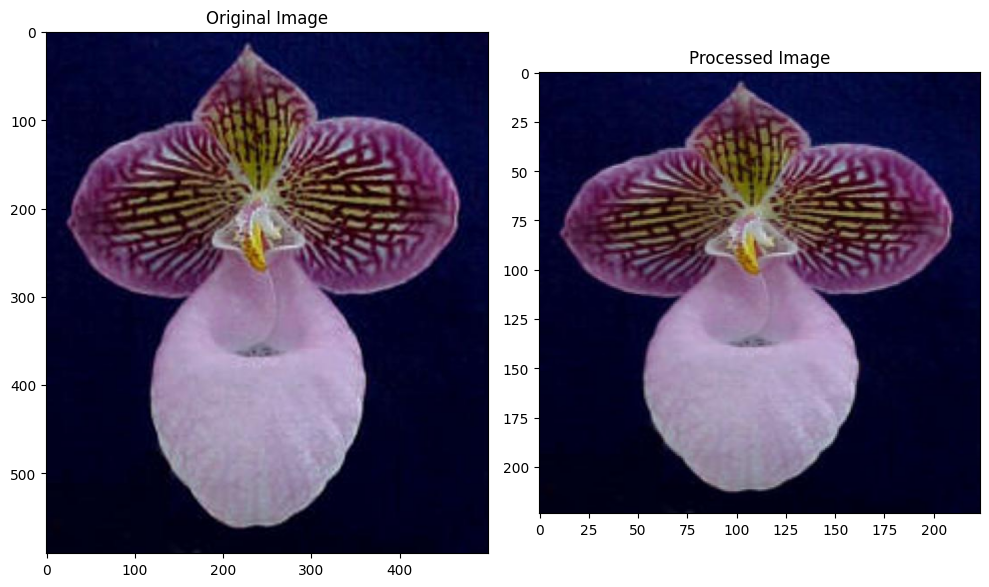

In [329]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [330]:
# TODO: Create the predict function

def predict(image_path, model, top_k=5):
    """Predict the top K classes for an input image using a trained model."""
    
    # Load and process the image
    image = Image.open(image_path)
    image = np.asarray(image)
    processed_image = process_image(image)
    
    # Expand dims to simulate batch size of 1
    input_tensor = np.expand_dims(processed_image, axis=0)
    
    # Run the prediction
    predictions = model.predict(input_tensor)
    
    # Get top k predictions
    top_k_indices = np.argsort(predictions[0])[-top_k:][::-1]
    top_k_probs = predictions[0][top_k_indices]
    
    # Convert indices to strings if needed
    top_k_classes = [str(index) for index in top_k_indices]
    
    return top_k_probs, top_k_classes

# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


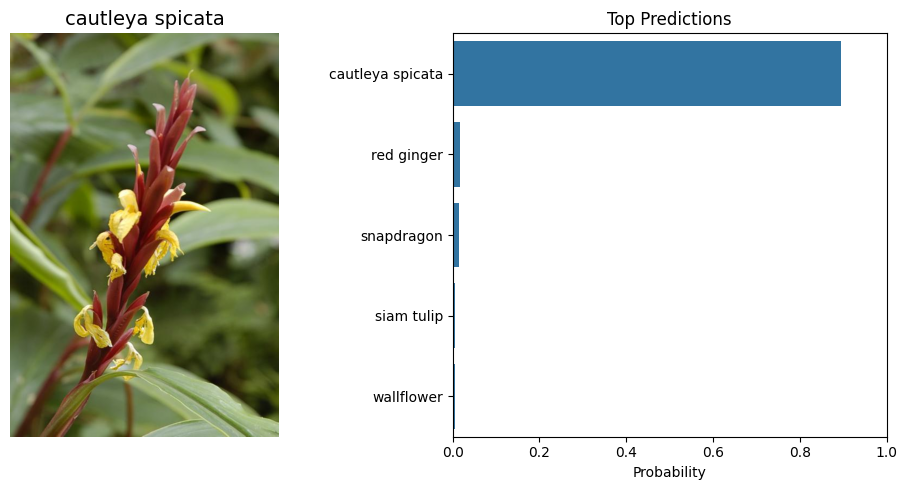

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


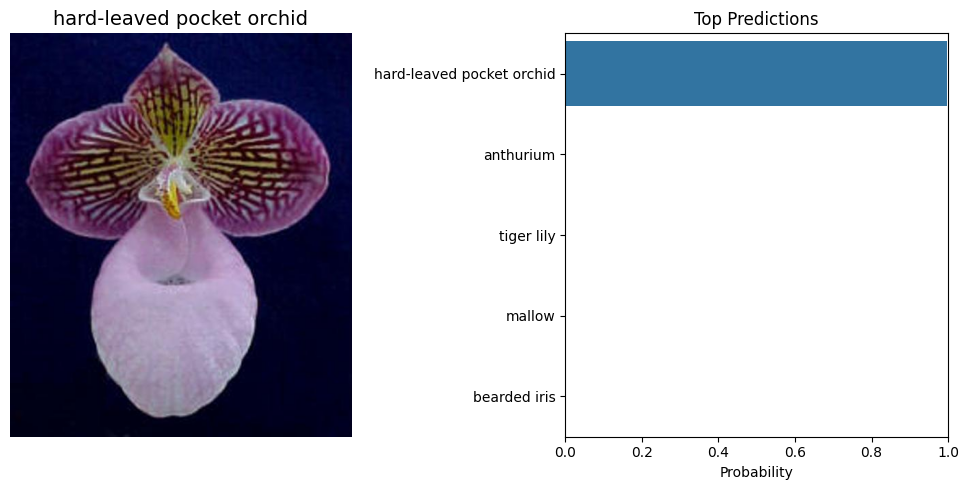

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


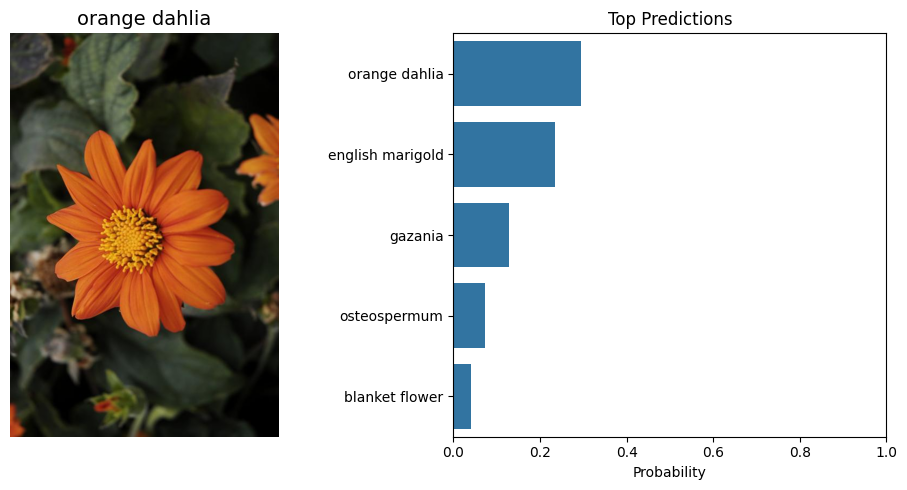

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


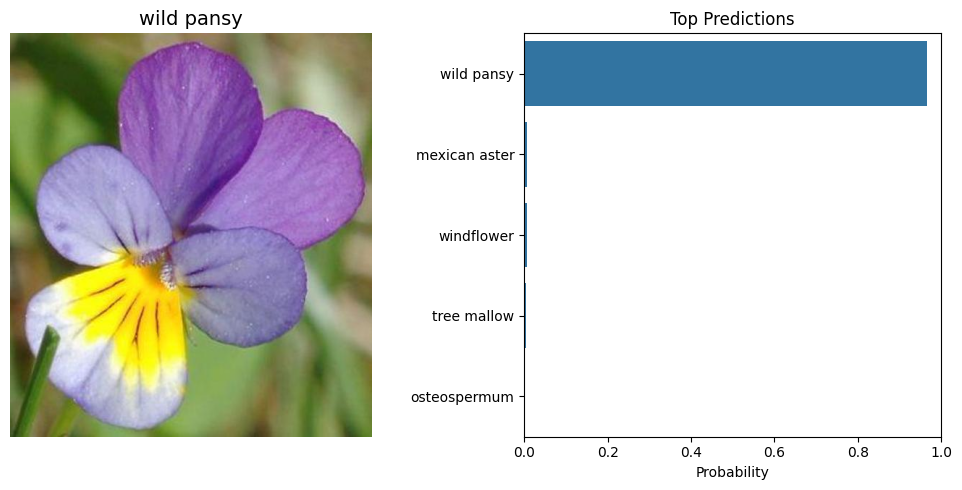

In [320]:
# TODO: Plot the input image along with the top 5 classes

def plot_prediction(image_path, model, class_names, top_k=5):
    """Plot image and model's top_k predictions with class names and probabilities side by side."""

    # Run prediction
    probs, classes = predict(image_path, model, top_k=top_k)

    # Map class indices to flower names
    class_labels = [class_names.get(cls, cls) for cls in classes]

    # Load image
    image = Image.open(image_path)

    # Set up side-by-side plots
    plt.figure(figsize=(10, 5))  # Wider layout

    # Left: Flower image
    ax1 = plt.subplot(1, 2, 1)
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title(class_labels[0], fontsize=14)  # Top predicted name

    # Right: Bar chart with top predictions
    ax2 = plt.subplot(1, 2, 2)
    sns.barplot(x=probs, y=class_labels, orient='h', ax=ax2)
    ax2.set_xlabel("Probability")
    ax2.set_xlim(0, 1)
    ax2.set_title("Top Predictions", fontsize=12)

    plt.tight_layout()
    plt.show()

images = ['test_images/cautleya_spicata.jpg', 'test_images/hard-leaved_pocket_orchid.jpg', 'test_images/orange_dahlia.jpg','test_images/wild_pansy.jpg']
for image in images:
    plot_prediction(image, model, class_names,top_k=5)